# Image Classification with a CNN on CIFAR-10

In this notebook, we will build, train, and evaluate a Convolutional Neural Network (CNN) to classify images from the CIFAR-10 dataset. We will provide detailed explanations for each step, including the purpose of each parameter and layer.

## 1. Imports and Dataset Loading

First, we import the necessary libraries:

- `tensorflow`: The main library for building and training neural networks.
- `datasets, layers, models`: Submodules from `tensorflow.keras` to load data and define our model layers.
- `matplotlib.pyplot`: To visualize sample images.
- `numpy`: For numerical operations and array handling.

Then, we load the CIFAR-10 dataset directly from Keras and normalize pixel values to the range [0, 1].

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image
from io import BytesIO

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Normalize pixel values from integers [0, 255] to floats [0.0, 1.0]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print('Training data shape:', x_train.shape)
print('Testing data shape:', x_test.shape)

Training data shape: (50000, 32, 32, 3)
Testing data shape: (10000, 32, 32, 3)


## 2. Visualizing the Data

Before training, it's helpful to see what the images look like. We have 10 classes:
`airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck`.
We will plot the first 5 images from the training set:

- `figsize=(10, 2)`: width and height of the figure in inches.
- `axes[i].imshow(...)`: Display the image at index `i`.
- `axes[i].set_title(...)`: Show the corresponding class name.
- `axes[i].axis('off')`: Hide axis ticks for clarity.

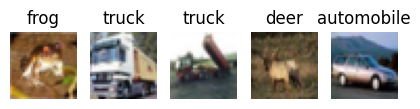

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

# Plot first 5 images
fig, axes = plt.subplots(1, 5, figsize=(5, 3))
for i in range(5):
    axes[i].imshow(x_train[i])
    label = y_train[i][0]  # y_train[i] is an array like [label]
    axes[i].set_title(class_names[label])
    axes[i].axis('off')
plt.show()

## 3. Building the CNN Model

We will define a Sequential CNN model consisting of:

1. **Conv2D layer** with:
   - `filters=32`: Number of convolutional kernels (feature detectors).
   - `kernel_size=(3, 3)`: Size of each kernel window.
   - `activation='relu'`: Rectified Linear Unit activation to introduce non-linearity.
   - `input_shape=(32, 32, 3)`: Shape of each input image (32x32 pixels, 3 color channels).
2. **MaxPooling2D layer** with:
   - `pool_size=(2, 2)`: Reduces each feature map by a factor of 2, retaining the most salient features.
3. A second Conv2D + MaxPooling block, with `filters=64` to learn more complex patterns.
4. **Flatten** layer to convert the 3D feature maps to a 1D feature vector.
5. **Dense** (fully connected) layers:
   - First Dense with `units=64` and `activation='relu'` to learn combinations of features.
   - Output Dense with `units=10` (one per class) and `activation='softmax'` to produce a probability distribution over classes.

In [3]:
from tensorflow.keras import models, layers

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),

    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax'),
])

model.summary()

/home/fablabs/jupyterhub/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,562 (654.54 KB)

 Trainable params: 167,562 (654.54 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Compiling and Training the Model

Before training, we must compile the model by specifying:

- `optimizer='adam'`: Adaptive Moment Estimation, a popular gradient-based optimizer.
- `loss='sparse_categorical_crossentropy'`: Appropriate for integer labels in multi-class classification.
- `metrics=['accuracy']`: Track accuracy during training.

We then train the model with:
- `epochs=10`: Number of complete passes through the training data.
- `batch_size=64`: Number of samples processed before updating the model's weights.
- `validation_data=(x_test, y_test)`: Evaluate performance on test set at each epoch.

In [4]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(x_test, y_test))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.3697 - loss: 1.7527 - val_accuracy: 0.5334 - val_loss: 1.3085
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5614 - loss: 1.2430 - val_accuracy: 0.6027 - val_loss: 1.1378
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6235 - loss: 1.0774 - val_accuracy: 0.6248 - val_loss: 1.0932
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6576 - loss: 0.9911 - val_accuracy: 0.6650 - val_loss: 0.9824
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.6858 - loss: 0.9063 - val_accuracy: 0.6761 - val_loss: 0.9436
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7020 - loss: 0.8585 - val_accuracy: 0.6825 - val_loss: 0.9405
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7220 - loss: 0.8004 - val_accuracy: 0.6870 - val_loss: 0.9229
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7334 - loss: 0.7745 - 

## 5. Evaluating the Model

After training, we evaluate the final performance on the test set using `evaluate`, which returns the loss and accuracy. A higher accuracy indicates better classification performance.

In [5]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.2%}')

313/313 - 1s - 3ms/step - accuracy: 0.6977 - loss: 0.8908
Test loss: 0.8908
Test accuracy: 69.77%


## 7. Classifying an External Image via URL

To demonstrate how our trained CNN can classify new, real-world images, we can load an image from any URL:

1. We prompt the user to enter an image URL.
2. We download the image using `requests` and open it with `PIL.Image`.
3. We convert it to RGB, resize it to the required input shape (32×32), and normalize pixel values to `[0.0, 1.0]`.
4. We expand dimensions to create a batch of size 1, which is needed for `model.predict`.
5. We run the model to obtain prediction probabilities.
6. We select the class with the highest probability and display both the class name and the probability.

In [8]:
# Pedir URL da imaxe
url = input("Image URL: ")

# Descargar e abrir a imaxe
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")

# Redimensionar a 32×32 e normalizar pixeles a [0,1]
img = img.resize((32, 32))
img_array = np.array(img).astype('float32') / 255.0

# Crear batch de tamaño 1
img_batch = np.expand_dims(img_array, axis=0)

# Predicción
preds = model.predict(img_batch)
class_idx = np.argmax(preds, axis=1)[0]
prob = preds[0][class_idx]

# Mostrar resultado
print(f"Predicted class: {class_names[class_idx]}  —  Probability: {prob:.2%}")


Image URL:  https://i.guim.co.uk/img/media/327aa3f0c3b8e40ab03b4ae80319064e401c6fbc/377_133_3542_2834/master/3542.jpg?width=465&dpr=1&s=none&crop=none


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted class: horse  —  Probability: 55.39%


## Summary and Next Steps

- We built a CNN with two convolutional blocks and dense layers for CIFAR-10 classification.
- We explained each layer, parameter, and hyperparameter in detail.
- Next, you can experiment with more layers, different optimizers, data augmentation, or regularization to improve performance.